In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# import the VGG16 model

vgg16_model = tf.keras.applications.vgg16.VGG16()

553467904/553467096 [==============================] - 123s 0us/step


In [5]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [3]:
# set up data paths

train_path = '../Cats and Dogs/PetImages/train/train'
valid_path = '../Cats and Dogs/PetImages/train/valid'
test_path = '../Cats and Dogs/PetImages/train/test'

In [4]:
# create batches

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [6]:
# convert VGG16 model to a sequential model
# leaving out the output layer - the current output is 1,000

model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [7]:
# since the model is pre-trained we'll freeze all the layers as non-trainable

for layer in model.layers:
    layer.trainable = False

In [8]:
# add the new output layer with only 2 nodes for cat and dog

model.add(Dense(units=2, activation='softmax'))

In [9]:
# looking at the summary we now see it has an output layer with 2 nodes
# and only 8194 trainable parameters

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [10]:
# compile the model

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# fit the model

model.fit(x=train_batches, steps_per_epoch=len(train_batches), 
          validation_data=valid_batches, validation_steps=len(valid_batches),
          epochs=5, verbose=2)

Epoch 1/5
100/100 - 232s - loss: 0.3721 - accuracy: 0.8420 - val_loss: 0.2232 - val_accuracy: 0.9250
Epoch 2/5
100/100 - 233s - loss: 0.0903 - accuracy: 0.9640 - val_loss: 0.1659 - val_accuracy: 0.9450
Epoch 3/5
100/100 - 237s - loss: 0.0576 - accuracy: 0.9810 - val_loss: 0.1445 - val_accuracy: 0.9500
Epoch 4/5
100/100 - 269s - loss: 0.0420 - accuracy: 0.9880 - val_loss: 0.1356 - val_accuracy: 0.9500
Epoch 5/5
100/100 - 231s - loss: 0.0327 - accuracy: 0.9920 - val_loss: 0.1200 - val_accuracy: 0.9550


We can see on the training set the accuracy is 99% and the loss is 0.03 which are both solid numbers. Even better is the validation set is close to those numbers with 96% accuracy and 0.12 loss. This means our model is not overfit.

In [12]:
# use our model to make predictions on the test data

predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [14]:
# define function to print and plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion Matrix',
                         cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix w/o Normalization')
    print(cm)    
    
    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix w/o Normalization
[[48  2]
 [ 1 49]]


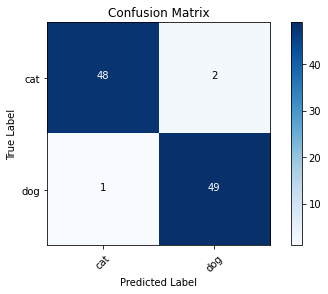

In [15]:
# create a confusion matrix to visualize the predicitons

cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

Out of the 100 images the model only predicted 3 incorrectly